# Chapter 15. STFFT

In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt

#import basic functions from numpy that we'll need
from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle, real, imag  
from numpy import zeros, ceil, floor, absolute, linspace
from numpy.fft import fft, ifft
from scipy import signal as sig
from scipy import stats
from scipy.signal import firls

import mne
import scipy.io
from pymatreader import read_mat

from matplotlib.pyplot import *

In [25]:
data = scipy.io.loadmat(r'\sampleEEGdata.mat') #load in the data
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]

EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

data_in = read_mat(r'\sampleEEGdata.mat') #another format to load in the data; used in the mne code block below
data_EEG = data_in['EEG']

 Q.1 Compute the short-time FFT at each electrode and make topographical maps of thetaband (around 6 Hz) power and alpha-band (around 10 Hz) power at 150 ms and 700 ms. 

In [27]:
timewin        = 400 # in ms, for stFFT
times2save     = np.arange(-300,1000 + 50,50) # in ms

# convert from ms to index
times2saveidx = np.zeros(times2save.shape);
for i in range(len(times2save)):
    times2saveidx[i]=np.argmin(absolute(EEGtimes-times2save[i]))

timewinidx = 128 #int(timewin/(1000/EEGsrate));

#create hann taper
hann_win = .5*(1-cos(2*pi*(np.arange(timewinidx))/(timewinidx-1)));
hann_win = np.reshape(hann_win,[len(hann_win),1])

#define frequencies
frex = linspace(0, EEGsrate/2, timewinidx//2+1);

p6_t_150 = np.zeros((64,1))
p10_t_150 = np.zeros((64,1))
p6_t_700 = np.zeros((64,1))
p10_t_700 = np.zeros((64,1))

for chan in np.arange(0,64,1):

    #initialize power output matrix
    tf = np.zeros([len(frex),len(times2save)])

    #loop over time points and perform FFT
    for timepointi in range(len(times2save)): 
        
        #extract time series data for this center time point
        # note: the 'mod' function here corrects for even or odd number of points
            
        selectedData = EEGdata[chan, int(times2saveidx[timepointi]-floor(timewinidx/2)-1):int(times2saveidx[timepointi]+floor(timewinidx/2)-((timewinidx+1)%2)),:]
            
        tempdat = np.squeeze(selectedData) #remove singleton dimension
        
        #multiply the two arrays together by broadcasting
        taperdat = tempdat * hann_win
        
        fdat = fft(taperdat,axis=0)/timewinidx # FFT and normalize by window length 
        tf[:,timepointi] = np.mean(absolute(fdat[:int(floor(timewinidx/2)+1),:])**2,axis=1) 
        
        p6_t_150[chan] = tf[3,9]
        p10_t_150[chan] = tf[5,9]
        
        p6_t_700[chan] = tf[3,20]
        p10_t_700[chan] = tf[5,20]
        
        
#p6_t_150       

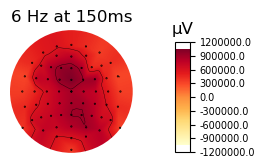

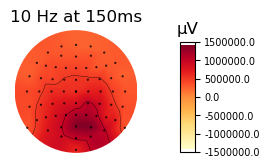

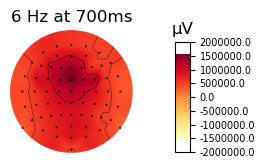

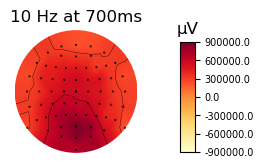

In [28]:
# create mne Evoked object

# create channel montage 
chan_labels = data_EEG['chanlocs']['labels']
coords = np.vstack([data_EEG['chanlocs']['Y'],data_EEG['chanlocs']['X'],data_EEG['chanlocs']['Z']]).T
montage = mne.channels.make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = mne.create_info(chan_labels, data_EEG['srate'] ,ch_types='eeg')
evoked = mne.EvokedArray(p6_t_150, info)
evoked.set_montage(montage);
#evoked
evoked.plot_topomap(times = evoked.times, ch_type='eeg', cmap = 'YlOrRd', image_interp = 'linear', time_format = '6 Hz at 150ms');

evoked = mne.EvokedArray(p10_t_150, info);
evoked.set_montage(montage);
evoked.plot_topomap(times = evoked.times,ch_type='eeg', cmap = 'YlOrRd', image_interp = 'linear', time_format = '10 Hz at 150ms');

evoked = mne.EvokedArray(p6_t_700, info);
evoked.set_montage(montage);
evoked.plot_topomap(times = evoked.times,ch_type='eeg', cmap = 'YlOrRd', image_interp = 'linear', time_format = '6 Hz at 700ms');

evoked = mne.EvokedArray(p10_t_700, info);
evoked.set_montage(montage);
evoked.plot_topomap(times = evoked.times,ch_type='eeg', cmap = 'YlOrRd', image_interp = 'linear', time_format = '10 Hz at 700ms');



Q.2  Select one electrode and one frequency and compute power over time at that electrode
and that frequency using complex wavelet convolution, filter-Hilbert, and the short-time
FFT. Plot the results of these three time-frequency decomposition methods in different subplots of one figure. Note that the scaling might be different because no baseline normalization has been applied. How visually similar are the results from these three methods? If the
results from the three methods are different, how are they different, and what parameters
do you think you could change in the three methods to make the results look more or less
similar? 

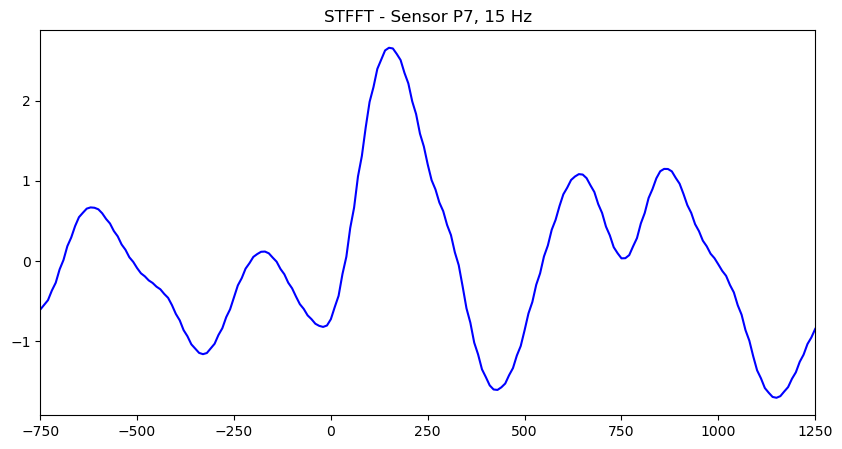

In [23]:
#STFFT

timewin        = 400 # in ms, for stFFT
times2save     = np.arange(-750,1250 + 10,10) # in ms
channel2plot   = 'P7'
frequency2plot = 15 # in Hz

# convert from ms to index
times2saveidx = np.zeros(times2save.shape);
for i in range(len(times2save)):
    times2saveidx[i]=np.argmin(absolute(EEGtimes-times2save[i]))

timewinidx = int(timewin/(1000/EEGsrate));
chan2useidx = EEGchanlocslabels == channel2plot

#create hann taper
hann_win = .5*(1-cos(2*pi*(np.arange(timewinidx))/(timewinidx-1)));
hann_win = np.reshape(hann_win,[len(hann_win),1])

#define frequencies
frex = linspace(0, EEGsrate/2, timewinidx//2+1);

#initialize power output matrix
tf = np.zeros([len(frex),len(times2save)])

#loop over time points and perform FFT
for timepointi in range(len(times2save)):
    
    #extract time series data for this center time point
    # note: the 'mod' function here corrects for even or odd number of points
        
    selectedData = EEGdata[chan2useidx, int(times2saveidx[timepointi]-floor(timewinidx/2)-1):int(times2saveidx[timepointi]+floor(timewinidx/2)-((timewinidx+1)%2)),:]
        
    tempdat = np.squeeze(selectedData) 
    
    #multiply the two arrays together by broadcasting
    taperdat = tempdat * hann_win
    
    fdat = fft(taperdat,axis=0)/timewinidx #
    tf[:,timepointi] = np.mean(absolute(fdat[:int(floor(timewinidx/2)+1),:])**2,axis=1) 

plt.figure(figsize=(10, 5))
freq2plotidx=np.argmin(absolute(frex-frequency2plot));
plot(times2save,stats.zscore(np.mean(log10(tf[freq2plotidx-3:freq2plotidx+3,:]),axis=0)), color = 'blue')
title('STFFT - Sensor ' + channel2plot + ', ' + str(frequency2plot) +' Hz' )
_=setp(gca(),'xlim',[times2save[0] ,times2save[-1]])
plt.show()

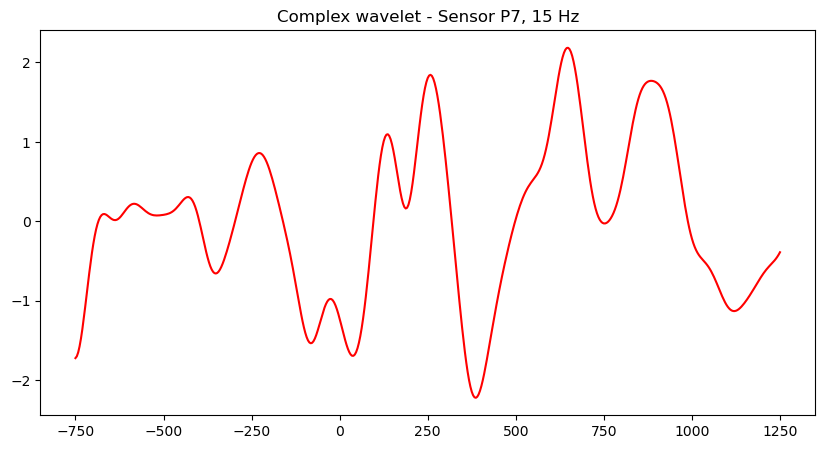

In [20]:
# convolve data1 with a complex morlet wavelet

power_matrix = np.empty((1, len(data_EEG['data'][22,:,0]))) # initialize matrix for power values; 22 is P7

for trials in np.arange(0,99,1):    

    # define wavelet parameters
    freq = 15  # frequency of wavelet
    csw = 5   # cycles per wavelet
    wavtime = np.arange(-1,1+1/EEGsrate,1/EEGsrate) # wavelet time vector
    half_wave = (len(wavtime)-1)/2
    s = csw/(2*pi*freq)
    cmw = exp(2*1j*pi*freq*wavtime) * exp(-wavtime**2/(2*s**2)) # complex morlet wavelet

    data_1 = data_EEG['data'][22,:,trials]

    # convolve data with wavelet
    convres = np.convolve(data_1,cmw)

    # cut off edges
    convres = convres[int(half_wave):-int(half_wave)]
    convres.shape

    # Extract the amplitude, power, and phase of the complex convolution result
    convres_amplitude = np.abs(convres)
    convres_power = convres_amplitude**2


    power_matrix = np.vstack([power_matrix,convres_power])

pow_matrix_mean = np.mean(power_matrix[1:,:],axis = 0)  

plt.figure(figsize=(10, 5))
plot(data_EEG['times'][64:577],stats.zscore(log10(pow_matrix_mean[64:577])), color = 'red')
title( 'Complex wavelet - Sensor ' + channel2plot + ', ' + str(frequency2plot) +' Hz' )
plt.show()

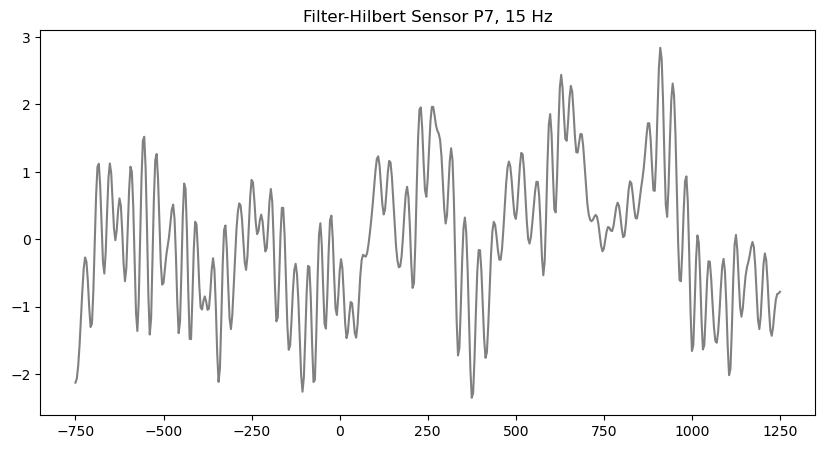

In [21]:
# Filter-Hilbert method

power_matrix_hil = np.empty((1, len(data_EEG['data'][22,:,0]))) # initialize matrix for power values; 22 is P7
idealresponse  = np.array([ 0, 0, 1 ,1, 0, 0 ])

for trials in np.arange(0,99,1):  
    center_freq   = 15
    nyquist     = EEGsrate/2
    freqspread    = 4 #  Hz +/- the center frequency
    transwid      = .10
    ffrequencies  = np.array([ 0, (1-transwid)*(center_freq-freqspread), (center_freq-freqspread), (center_freq+freqspread),(1+transwid)*(center_freq+freqspread), nyquist ])/nyquist

    data2filter   = np.squeeze(EEGdata[22,:,trials])
    filterweights = firls(201,ffrequencies,idealresponse) # recompute without z-scoring

    filter_result = sig.filtfilt(filterweights,1,data2filter)
    power_matrix_hil = np.vstack([power_matrix_hil,filter_result**2])
    
pow_matrix_hil_mean = np.mean(power_matrix_hil[1:,:],axis = 0)

plt.figure(figsize=(10, 5))
plot(data_EEG['times'][64:577],stats.zscore(log10(pow_matrix_hil_mean[64:577])), color = 'grey')
title( 'Filter-Hilbert Sensor ' + channel2plot + ', ' + str(frequency2plot) +' Hz' )
plt.show()        

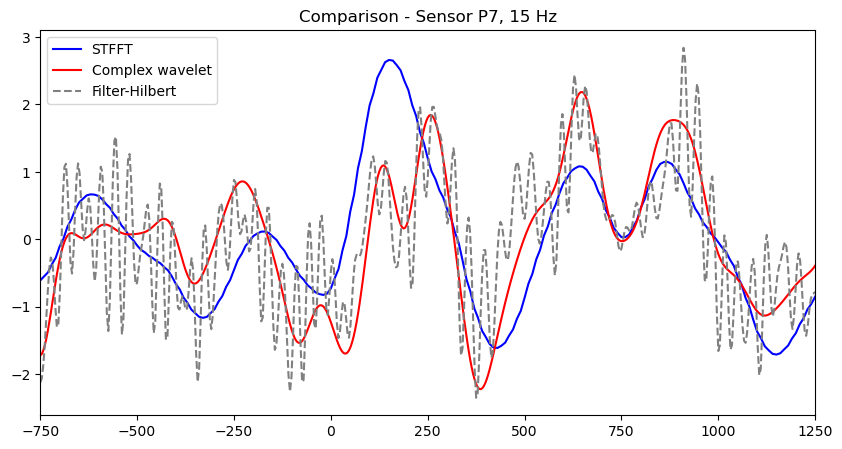

In [22]:
plt.figure(figsize=(10, 5))
freq2plotidx=np.argmin(absolute(frex-frequency2plot));
plot(times2save,stats.zscore(np.mean(log10(tf[freq2plotidx-3:freq2plotidx+3,:]),axis=0)), color = 'blue')
plot(data_EEG['times'][64:577],stats.zscore(log10(pow_matrix_mean[64:577])), color = 'red')
plot(data_EEG['times'][64:577],stats.zscore(log10(pow_matrix_hil_mean[64:577])), color = 'grey', linestyle = '--')
title( 'Comparison - Sensor ' + channel2plot + ', ' + str(frequency2plot) +' Hz' )
_=setp(gca(),'xlim',[times2save[0] ,times2save[-1]])
plt.legend(['STFFT','Complex wavelet', 'Filter-Hilbert'], loc = 'upper left')
plt.show()